In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
import os
print(os.listdir("../input"))
warnings.filterwarnings("ignore")
# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


In [2]:
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
import seaborn as sns
import pywt 
from statsmodels.robust import mad
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [3]:
from numba import jit
from math import log, floor
from sklearn.neighbors import KDTree
from scipy.signal import periodogram, welch
def petrosian_fd(x):
    """Petrosian fractal dimension.
    Parameters
    ----------
    x : list or np.array
        One dimensional time series
    Returns
    -------
    pfd : float
        Petrosian fractal dimension
    Notes
    -----
    The Petrosian algorithm can be used to provide a fast computation of
    the FD of a signal by translating the series into a binary sequence.
    The Petrosian fractal dimension of a time series :math:`x` is defined by:
    .. math:: \dfrac{log_{10}(N)}{log_{10}(N) +
       log_{10}(\dfrac{N}{N+0.4N_{\Delta}})}
    where :math:`N` is the length of the time series, and
    :math:`N_{\Delta}` is the number of sign changes in the binary sequence.
    Original code from the pyrem package by Quentin Geissmann.
    References
    ----------
    .. [1] A. Petrosian, Kolmogorov complexity of finite sequences and
       recognition of different preictal EEG patterns, in , Proceedings of the
       Eighth IEEE Symposium on Computer-Based Medical Systems, 1995,
       pp. 212-217.
    .. [2] Goh, Cindy, et al. "Comparison of fractal dimension algorithms for
       the computation of EEG biomarkers for dementia." 2nd International
       Conference on Computational Intelligence in Medicine and Healthcare
       (CIMED2005). 2005.
    Examples
    --------
    Petrosian fractal dimension.
        >>> import numpy as np
        >>> from entropy import petrosian_fd
        >>> np.random.seed(123)
        >>> x = np.random.rand(100)
        >>> print(petrosian_fd(x))
            1.0505
    """
    n = len(x)
    # Number of sign changes in the first derivative of the signal
    diff = np.ediff1d(x)
    N_delta = (diff[1:-1] * diff[0:-2] < 0).sum()
    return np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * N_delta)))


def katz_fd(x):
    """Katz Fractal Dimension.
    Parameters
    ----------
    x : list or np.array
        One dimensional time series
    Returns
    -------
    kfd : float
        Katz fractal dimension
    Notes
    -----
    The Katz Fractal dimension is defined by:
    .. math:: FD_{Katz} = \dfrac{log_{10}(n)}{log_{10}(d/L)+log_{10}(n)}
    where :math:`L` is the total length of the time series and :math:`d`
    is the Euclidean distance between the first point in the
    series and the point that provides the furthest distance
    with respect to the first point.
    Original code from the mne-features package by Jean-Baptiste Schiratti
    and Alexandre Gramfort.
    References
    ----------
    .. [1] Esteller, R. et al. (2001). A comparison of waveform fractal
           dimension algorithms. IEEE Transactions on Circuits and Systems I:
           Fundamental Theory and Applications, 48(2), 177-183.
    .. [2] Goh, Cindy, et al. "Comparison of fractal dimension algorithms for
           the computation of EEG biomarkers for dementia." 2nd International
           Conference on Computational Intelligence in Medicine and Healthcare
           (CIMED2005). 2005.
    Examples
    --------
    Katz fractal dimension.
        >>> import numpy as np
        >>> from entropy import katz_fd
        >>> np.random.seed(123)
        >>> x = np.random.rand(100)
        >>> print(katz_fd(x))
            5.1214
    """
    x = np.array(x)
    dists = np.abs(np.ediff1d(x))
    ll = dists.sum()
    ln = np.log10(np.divide(ll, dists.mean()))
    aux_d = x - x[0]
    d = np.max(np.abs(aux_d[1:]))
    return np.divide(ln, np.add(ln, np.log10(np.divide(d, ll))))

@jit('UniTuple(float64, 2)(float64[:], float64[:])', nopython=True)
def _linear_regression(x, y):
    """Fast linear regression using Numba.
    Parameters
    ----------
    x, y : ndarray, shape (n_times,)
        Variables
    Returns
    -------
    slope : float
        Slope of 1D least-square regression.
    intercept : float
        Intercept
    """
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    return slope, intercept


@jit('i8[:](f8, f8, f8)', nopython=True)
def _log_n(min_n, max_n, factor):
    """
    Creates a list of integer values by successively multiplying a minimum
    value min_n by a factor > 1 until a maximum value max_n is reached.
    Used for detrended fluctuation analysis (DFA).
    Function taken from the nolds python package
    (https://github.com/CSchoel/nolds) by Christopher Scholzel.
    Parameters
    ----------
    min_n (float):
        minimum value (must be < max_n)
    max_n (float):
        maximum value (must be > min_n)
    factor (float):
       factor used to increase min_n (must be > 1)
    Returns
    -------
    list of integers:
        min_n, min_n * factor, min_n * factor^2, ... min_n * factor^i < max_n
        without duplicates
    """
    max_i = int(floor(log(1.0 * max_n / min_n) / log(factor)))
    ns = [min_n]
    for i in range(max_i + 1):
        n = int(floor(min_n * (factor ** i)))
        if n > ns[-1]:
            ns.append(n)
    return np.array(ns, dtype=np.int64)

@jit('float64(float64[:], int32)')
def _higuchi_fd(x, kmax):
    """Utility function for `higuchi_fd`.
    """
    n_times = x.size
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
        # Mean of lm
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        m_lm /= k
        lk[k - 1] = m_lm
        x_reg[k - 1] = log(1. / k)
        y_reg[k - 1] = log(m_lm)
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi


def higuchi_fd(x, kmax=10):
    """Higuchi Fractal Dimension.
    Parameters
    ----------
    x : list or np.array
        One dimensional time series
    kmax : int
        Maximum delay/offset (in number of samples).
    Returns
    -------
    hfd : float
        Higuchi Fractal Dimension
    Notes
    -----
    Original code from the mne-features package by Jean-Baptiste Schiratti
    and Alexandre Gramfort.
    The `higuchi_fd` function uses Numba to speed up the computation.
    References
    ----------
    .. [1] Higuchi, Tomoyuki. "Approach to an irregular time series on the
       basis of the fractal theory." Physica D: Nonlinear Phenomena 31.2
       (1988): 277-283.
    Examples
    --------
    Higuchi Fractal Dimension
        >>> import numpy as np
        >>> from entropy import higuchi_fd
        >>> np.random.seed(123)
        >>> x = np.random.rand(100)
        >>> print(higuchi_fd(x))
            2.051179
    """
    x = np.asarray(x, dtype=np.float64)
    kmax = int(kmax)
    return _higuchi_fd(x, kmax)
def _embed(x, order=3, delay=1):
    """Time-delay embedding.
    Parameters
    ----------
    x : 1d-array, shape (n_times)
        Time series
    order : int
        Embedding dimension (order)
    delay : int
        Delay.
    Returns
    -------
    embedded : ndarray, shape (n_times - (order - 1) * delay, order)
        Embedded time-series.
    """
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

all = ['perm_entropy', 'spectral_entropy', 'svd_entropy', 'app_entropy',
       'sample_entropy']


def perm_entropy(x, order=3, delay=1, normalize=False):
    """Permutation Entropy.
    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int
        Order of permutation entropy
    delay : int
        Time delay
    normalize : bool
        If True, divide by log2(order!) to normalize the entropy between 0
        and 1. Otherwise, return the permutation entropy in bit.
    Returns
    -------
    pe : float
        Permutation Entropy
    Notes
    -----
    The permutation entropy is a complexity measure for time-series first
    introduced by Bandt and Pompe in 2002 [1]_.
    The permutation entropy of a signal :math:`x` is defined as:
    .. math:: H = -\sum p(\pi)log_2(\pi)
    where the sum runs over all :math:`n!` permutations :math:`\pi` of order
    :math:`n`. This is the information contained in comparing :math:`n`
    consecutive values of the time series. It is clear that
    :math:`0 ≤ H (n) ≤ log_2(n!)` where the lower bound is attained for an
    increasing or decreasing sequence of values, and the upper bound for a
    completely random system where all :math:`n!` possible permutations appear
    with the same probability.
    The embedded matrix :math:`Y` is created by:
    .. math:: y(i)=[x_i,x_{i+delay}, ...,x_{i+(order-1) * delay}]
    .. math:: Y=[y(1),y(2),...,y(N-(order-1))*delay)]^T
    References
    ----------
    .. [1] Bandt, Christoph, and Bernd Pompe. "Permutation entropy: a
           natural complexity measure for time series." Physical review letters
           88.17 (2002): 174102.
    Examples
    --------
    1. Permutation entropy with order 2
        >>> from entropy import perm_entropy
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value in bit between 0 and log2(factorial(order))
        >>> print(perm_entropy(x, order=2))
            0.918
    2. Normalized permutation entropy with order 3
        >>> from entropy import perm_entropy
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value comprised between 0 and 1.
        >>> print(perm_entropy(x, order=3, normalize=True))
            0.589
    """
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe


def spectral_entropy(x, sf, method='fft', nperseg=None, normalize=False):
    """Spectral Entropy.
    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    sf : float
        Sampling frequency
    method : str
        Spectral estimation method ::
        'fft' : Fourier Transform (via scipy.signal.periodogram)
        'welch' : Welch periodogram (via scipy.signal.welch)
    nperseg : str or int
        Length of each FFT segment for Welch method.
        If None, uses scipy default of 256 samples.
    normalize : bool
        If True, divide by log2(psd.size) to normalize the spectral entropy
        between 0 and 1. Otherwise, return the spectral entropy in bit.
    Returns
    -------
    se : float
        Spectral Entropy
    Notes
    -----
    Spectral Entropy is defined to be the Shannon Entropy of the Power
    Spectral Density (PSD) of the data:
    .. math:: H(x, sf) =  -\sum_{f=0}^{f_s/2} PSD(f) log_2[PSD(f)]
    Where :math:`PSD` is the normalised PSD, and :math:`f_s` is the sampling
    frequency.
    References
    ----------
    .. [1] Inouye, T. et al. (1991). Quantification of EEG irregularity by
       use of the entropy of the power spectrum. Electroencephalography
       and clinical neurophysiology, 79(3), 204-210.
    Examples
    --------
    1. Spectral entropy of a pure sine using FFT
        >>> from entropy import spectral_entropy
        >>> import numpy as np
        >>> sf, f, dur = 100, 1, 4
        >>> N = sf * duration # Total number of discrete samples
        >>> t = np.arange(N) / sf # Time vector
        >>> x = np.sin(2 * np.pi * f * t)
        >>> print(np.round(spectral_entropy(x, sf, method='fft'), 2)
            0.0
    2. Spectral entropy of a random signal using Welch's method
        >>> from entropy import spectral_entropy
        >>> import numpy as np
        >>> np.random.seed(42)
        >>> x = np.random.rand(3000)
        >>> print(spectral_entropy(x, sf=100, method='welch'))
            9.939
    3. Normalized spectral entropy
        >>> print(spectral_entropy(x, sf=100, method='welch', normalize=True))
            0.995
    """
    x = np.array(x)
    # Compute and normalize power spectrum
    if method == 'fft':
        _, psd = periodogram(x, sf)
    elif method == 'welch':
        _, psd = welch(x, sf, nperseg=nperseg)
    psd_norm = np.divide(psd, psd.sum())
    se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
    if normalize:
        se /= np.log2(psd_norm.size)
    return se


def svd_entropy(x, order=3, delay=1, normalize=False):
    """Singular Value Decomposition entropy.
    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int
        Order of permutation entropy
    delay : int
        Time delay
    normalize : bool
        If True, divide by log2(order!) to normalize the entropy between 0
        and 1. Otherwise, return the permutation entropy in bit.
    Returns
    -------
    svd_e : float
        SVD Entropy
    Notes
    -----
    SVD entropy is an indicator of the number of eigenvectors that are needed
    for an adequate explanation of the data set. In other words, it measures
    the dimensionality of the data.
    The SVD entropy of a signal :math:`x` is defined as:
    .. math::
        H = -\sum_{i=1}^{M} \overline{\sigma}_i log_2(\overline{\sigma}_i)
    where :math:`M` is the number of singular values of the embedded matrix
    :math:`Y` and :math:`\sigma_1, \sigma_2, ..., \sigma_M` are the
    normalized singular values of :math:`Y`.
    The embedded matrix :math:`Y` is created by:
    .. math:: y(i)=[x_i,x_{i+delay}, ...,x_{i+(order-1) * delay}]
    .. math:: Y=[y(1),y(2),...,y(N-(order-1))*delay)]^T
    Examples
    --------
    1. SVD entropy with order 2
        >>> from entropy import svd_entropy
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value in bit between 0 and log2(factorial(order))
        >>> print(svd_entropy(x, order=2))
            0.762
    2. Normalized SVD entropy with order 3
        >>> from entropy import svd_entropy
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value comprised between 0 and 1.
        >>> print(svd_entropy(x, order=3, normalize=True))
            0.687
    """
    x = np.array(x)
    mat = _embed(x, order=order, delay=delay)
    W = np.linalg.svd(mat, compute_uv=False)
    # Normalize the singular values
    W /= sum(W)
    svd_e = -np.multiply(W, np.log2(W)).sum()
    if normalize:
        svd_e /= np.log2(order)
    return svd_e


def _app_samp_entropy(x, order, metric='chebyshev', approximate=True):
    """Utility function for `app_entropy`` and `sample_entropy`.
    """
    _all_metrics = KDTree.valid_metrics
    if metric not in _all_metrics:
        raise ValueError('The given metric (%s) is not valid. The valid '
                         'metric names are: %s' % (metric, _all_metrics))
    phi = np.zeros(2)
    r = 0.2 * np.std(x, axis=-1, ddof=1)

    # compute phi(order, r)
    _emb_data1 = _embed(x, order, 1)
    if approximate:
        emb_data1 = _emb_data1
    else:
        emb_data1 = _emb_data1[:-1]
    count1 = KDTree(emb_data1, metric=metric).query_radius(emb_data1, r,
                                                           count_only=True
                                                           ).astype(np.float64)
    # compute phi(order + 1, r)
    emb_data2 = _embed(x, order + 1, 1)
    count2 = KDTree(emb_data2, metric=metric).query_radius(emb_data2, r,
                                                           count_only=True
                                                           ).astype(np.float64)
    if approximate:
        phi[0] = np.mean(np.log(count1 / emb_data1.shape[0]))
        phi[1] = np.mean(np.log(count2 / emb_data2.shape[0]))
    else:
        phi[0] = np.mean((count1 - 1) / (emb_data1.shape[0] - 1))
        phi[1] = np.mean((count2 - 1) / (emb_data2.shape[0] - 1))
    return phi


@jit('f8(f8[:], i4, f8)', nopython=True)
def _numba_sampen(x, mm=2, r=0.2):
    """
    Fast evaluation of the sample entropy using Numba.
    """
    n = x.size
    n1 = n - 1
    mm += 1
    mm_dbld = 2 * mm

    # Define threshold
    r *= x.std()

    # initialize the lists
    run = [0] * n
    run1 = run[:]
    r1 = [0] * (n * mm_dbld)
    a = [0] * mm
    b = a[:]
    p = a[:]

    for i in range(n1):
        nj = n1 - i

        for jj in range(nj):
            j = jj + i + 1
            if abs(x[j] - x[i]) < r:
                run[jj] = run1[jj] + 1
                m1 = mm if mm < run[jj] else run[jj]
                for m in range(m1):
                    a[m] += 1
                    if j < n1:
                        b[m] += 1
            else:
                run[jj] = 0
        for j in range(mm_dbld):
            run1[j] = run[j]
            r1[i + n * j] = run[j]
        if nj > mm_dbld - 1:
            for j in range(mm_dbld, nj):
                run1[j] = run[j]

    m = mm - 1

    while m > 0:
        b[m] = b[m - 1]
        m -= 1

    b[0] = n * n1 / 2
    a = np.array([float(aa) for aa in a])
    b = np.array([float(bb) for bb in b])
    p = np.true_divide(a, b)
    return -log(p[-1])


def app_entropy(x, order=2, metric='chebyshev'):
    """Approximate Entropy.
    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int (default: 2)
        Embedding dimension.
    metric : str (default: chebyshev)
        Name of the metric function used with
        :class:`~sklearn.neighbors.KDTree`. The list of available
        metric functions is given by: ``KDTree.valid_metrics``.
    Returns
    -------
    ae : float
        Approximate Entropy.
    Notes
    -----
    Original code from the mne-features package.
    Approximate entropy is a technique used to quantify the amount of
    regularity and the unpredictability of fluctuations over time-series data.
    Smaller values indicates that the data is more regular and predictable.
    The value of :math:`r` is set to :math:`0.2 * std(x)`.
    Code adapted from the mne-features package by Jean-Baptiste Schiratti
    and Alexandre Gramfort.
    References
    ----------
    .. [1] Richman, J. S. et al. (2000). Physiological time-series analysis
           using approximate entropy and sample entropy. American Journal of
           Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.
    1. Approximate entropy with order 2.
        >>> from entropy import app_entropy
        >>> import numpy as np
        >>> np.random.seed(1234567)
        >>> x = np.random.rand(3000)
        >>> print(app_entropy(x, order=2))
            2.075
    """
    phi = _app_samp_entropy(x, order=order, metric=metric, approximate=True)
    return np.subtract(phi[0], phi[1])


def sample_entropy(x, order=2, metric='chebyshev'):
    """Sample Entropy.
    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int (default: 2)
        Embedding dimension.
    metric : str (default: chebyshev)
        Name of the metric function used with KDTree. The list of available
        metric functions is given by: `KDTree.valid_metrics`.
    Returns
    -------
    se : float
        Sample Entropy.
    Notes
    -----
    Sample entropy is a modification of approximate entropy, used for assessing
    the complexity of physiological time-series signals. It has two advantages
    over approximate entropy: data length independence and a relatively
    trouble-free implementation. Large values indicate high complexity whereas
    smaller values characterize more self-similar and regular signals.
    Sample entropy of a signal :math:`x` is defined as:
    .. math:: H(x, m, r) = -log\dfrac{C(m + 1, r)}{C(m, r)}
    where :math:`m` is the embedding dimension (= order), :math:`r` is
    the radius of the neighbourhood (default = :math:`0.2 * std(x)`),
    :math:`C(m + 1, r)` is the number of embedded vectors of length
    :math:`m + 1` having a Chebyshev distance inferior to :math:`r` and
    :math:`C(m, r)` is the number of embedded vectors of length
    :math:`m` having a Chebyshev distance inferior to :math:`r`.
    Note that if metric == 'chebyshev' and x.size < 5000 points, then the
    sample entropy is computed using a fast custom Numba script. For other
    metric types or longer time-series, the sample entropy is computed using
    a code from the mne-features package by Jean-Baptiste Schiratti
    and Alexandre Gramfort (requires sklearn).
    References
    ----------
    .. [1] Richman, J. S. et al. (2000). Physiological time-series analysis
           using approximate entropy and sample entropy. American Journal of
           Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.
    Examples
    --------
    1. Sample entropy with order 2.
        >>> from entropy import sample_entropy
        >>> import numpy as np
        >>> np.random.seed(1234567)
        >>> x = np.random.rand(3000)
        >>> print(sample_entropy(x, order=2))
            2.192
    2. Sample entropy with order 3 using the Euclidean distance.
        >>> from entropy import sample_entropy
        >>> import numpy as np
        >>> np.random.seed(1234567)
        >>> x = np.random.rand(3000)
        >>> print(sample_entropy(x, order=3, metric='euclidean'))
            2.725
    """
    x = np.asarray(x, dtype=np.float64)
    if metric == 'chebyshev' and x.size < 5000:
        return _numba_sampen(x, mm=order, r=0.2)
    else:
        phi = _app_samp_entropy(x, order=order, metric=metric,
                                approximate=False)
        return -np.log(np.divide(phi[1], phi[0]))

In [4]:
rows = 150_000
periods=50000
segments = int(np.floor(train.shape[0] / rows))

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest(coeff[-level])

    # Calculate the univeral threshold
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')
from tsfresh.feature_extraction import feature_calculators
def calc_change_rate(x):
    change = np.diff(x) / x[:-1]
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)
def periodic_apply(x,period,func,*args):
    seg=int(np.floor(len(x)/period))
    result=[]
    for seg_id in range(seg):
        sg=x[seg_id*period:seg_id*period+period]
        result.append(func(sg,*args))
    return result
from scipy.signal import find_peaks, peak_widths, peak_prominences
from scipy import signal

def remove_false_peak(signal, p1, p2, maxDistance=10):
    peak_diff = np.diff(p2)
    if len(peak_diff) == 0:
        return p1
    ticks = []
    for i, d in enumerate(peak_diff):
        ratio = signal[p2[i+1]]/signal[p2[i]]
        if d < maxDistance and -0.25 > ratio and ratio > -4:
            ticks.append((p2[i], p2[i+1]))
    mask = np.array([True]*len(p1))
    for i, j in ticks:
        mask = mask; ((p1 < i) | (p1 > 500+j))
    return p1[mask]


def get_peaks(signal):
    p1_1, _ = find_peaks(signal, height=[5, 100])
    p1_2, _ = find_peaks(-signal, height=[5, 100])
    p1 = np.union1d(p1_1, p1_2)
    n_peaks, _ = find_peaks(-signal, height=[10, 100])
    p_peaks, _ = find_peaks(signal, height=[10, 100])
    p2 = np.union1d(n_peaks, p_peaks)
    p = remove_false_peak(signal, p1, p2, maxDistance=100)
    return np.intersect1d(p1_1, p), np.intersect1d(p1_2, p)


def extract_peak_feature(signal):
    p_peaks, n_peaks = get_peaks(signal)

    num_p, num_n = len(p_peaks), len(n_peaks)

    sig_peak_width = np.concatenate(
        [peak_widths(signal, p_peaks)[0], peak_widths(-signal, n_peaks)[0]])
    sig_peak_height = abs(signal[np.concatenate([p_peaks, n_peaks])])

    if num_n or num_p:
        height_mean = sig_peak_height.mean()
        height_max = sig_peak_height.max()
        height_min = sig_peak_height.min()
        height_median = np.median(sig_peak_height)

        width_mean = sig_peak_width.mean()
        width_max = sig_peak_width.max()
        width_min = sig_peak_width.min()
        width_median = np.median(sig_peak_width)

        return np.array([height_max,
                         width_mean, width_median])
    else:
        return np.zeros(3)
    
def entropy_and_fractal_dim(x):
    return [
#        perm_entropy(x),
            svd_entropy(x),
#            app_entropy(x),
#            sample_entropy(x),
 #           petrosian_fd(x),
#            katz_fd(x),
#            higuchi_fd(x)
    ]
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    x = pd.Series(seg['acoustic_data'].values)
    xc=denoise_signal(xc.values)
    
    
    X.loc[seg_id, 'number_crossing_0'] = feature_calculators.number_crossing_m(x, 0)
    X.loc[seg_id, 'q05_roll_std_10'] = np.quantile(x.rolling(10).std().dropna().values, 0.05)
    X.loc[seg_id,'peak_feature_2'],X.loc[seg_id,'peak_feature_5'],X.loc[seg_id,'peak_feature_8']=extract_peak_feature(xc)
    X.loc[seg_id,'svd_entropy']=svd_entropy(xc)
    X.loc[seg_id,'c3']=feature_calculators.c3(xc, 1000)
#    X.loc[seg_id,'mode_median_mean_otn']=(x.mode()[0]/x.mean())/(x.mode()[0]/x.median())
    distance_between_peaks=np.diff(signal.find_peaks(xc,height=40)[0])
    try:
        X.loc[seg_id,'diff_peaks40_max']=distance_between_peaks.max()
    except ValueError:
        X.loc[seg_id,'diff_peaks40_max']=0
    
    X.loc[seg_id,'std_roll_percentile']=np.percentile(x.rolling(1000).std().dropna().values, 20)
    X.loc[seg_id,'std_roll_percentile_5']=np.percentile(x.rolling(1000).std().dropna().values, 5)
#    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id,'limit_last']=np.where((xc[-5000:]>3.5)&(xc[-5000:]<5),1,0).sum()/5000
    
#    X.loc[seg_id,'change_rate_otnLITTLE']=calc_change_rate(xc[:5000])/calc_change_rate(xc[-5000:])
    
    
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)        
for seg_id in tqdm_notebook(range(segments)):
    seg = train.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_X.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

from sklearn.preprocessing import StandardScaler    
scaler = StandardScaler()
y=train_X['time_to_failure'].values
train_X=train_X.drop(['time_to_failure'],axis=1)
scaler.fit(train_X)
train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
train_X['time_to_failure']=y
#train_X.to_csv('train_data.csv')

In [5]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.drop(['time_to_failure'],axis=1).columns, dtype=np.float64, index=submission.index)
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    create_features(seg_id, seg, test_X)
test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)
#test_X.to_csv('test_data.csv')

In [6]:
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from catboost import Pool, CatBoostRegressor
num_folds=5
rskf=KFold(num_folds,shuffle=True,random_state=42)
val_pr=np.zeros(len(train_X))
test_pr=np.zeros(len(test_X))
feature_importance_df = pd.DataFrame()
bor=['peak_feature_10']
train_columns=[name for name in train_X.columns if name not in ['time_to_failure','outlier'] and name not in bor]
#train_X['outlier']=0
#train_X.loc[train_X['time_to_failure']<1,'outlier']
for train_index,val_index in rskf.split(train_X):
#     targ=target_encoding(train_X.loc[train_index],'number_peak_60')
#     targ.fit()
#     train_data=targ.transform(train_X[train_columns].loc[train_index])
#     val_data=targ.transform(train_X[train_columns].loc[val_index])
    train_data=train_X[train_columns].loc[train_index]
    val_data=train_X[train_columns].loc[val_index]
    train_data=Pool(train_data,train_X['time_to_failure'].loc[train_index])
    val_data=Pool(val_data,train_X['time_to_failure'].loc[val_index])
    num_round=10000
    model=CatBoostRegressor(iterations=15000, learning_rate=0.01,loss_function='MAE',metric_period=100,use_best_model=True)
    model.fit(train_data,eval_set=val_data,use_best_model=True,early_stopping_rounds=100)
    fold_importance_df=pd.DataFrame()
    fold_importance_df['feature']=train_columns
    fold_importance_df['importance']=model.feature_importances_
    feature_importance_df=pd.concat([feature_importance_df,fold_importance_df],axis=0)
    val_pr[val_index]=model.predict(train_X[train_columns].loc[val_index])
    test_pr+=model.predict(test_X[train_columns])/num_folds
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(train_X['time_to_failure'].values,val_pr))

0:	learn: 5.6814720	test: 5.6630519	best: 5.6630519 (0)	total: 62ms	remaining: 15m 29s
100:	learn: 5.2343722	test: 5.2113059	best: 5.2113059 (100)	total: 888ms	remaining: 2m 11s
200:	learn: 4.8555782	test: 4.8346335	best: 4.8346335 (200)	total: 1.69s	remaining: 2m 4s
300:	learn: 4.5254231	test: 4.5103166	best: 4.5103166 (300)	total: 2.56s	remaining: 2m 5s
400:	learn: 4.2296492	test: 4.2186288	best: 4.2186288 (400)	total: 3.43s	remaining: 2m 5s
500:	learn: 3.9550844	test: 3.9561931	best: 3.9561931 (500)	total: 4.3s	remaining: 2m 4s
600:	learn: 3.6997810	test: 3.7113276	best: 3.7113276 (600)	total: 5.18s	remaining: 2m 4s
700:	learn: 3.4627687	test: 3.4801744	best: 3.4801744 (700)	total: 6.06s	remaining: 2m 3s
800:	learn: 3.2436837	test: 3.2612140	best: 3.2612140 (800)	total: 6.95s	remaining: 2m 3s
900:	learn: 3.0443747	test: 3.0565491	best: 3.0565491 (900)	total: 7.84s	remaining: 2m 2s
1000:	learn: 2.8634052	test: 2.8716921	best: 2.8716921 (1000)	total: 8.72s	remaining: 2m 1s
1100:	learn

0:	learn: 5.6902367	test: 5.6280186	best: 5.6280186 (0)	total: 9.92ms	remaining: 2m 28s
100:	learn: 5.2403185	test: 5.1803662	best: 5.1803662 (100)	total: 889ms	remaining: 2m 11s
200:	learn: 4.8619181	test: 4.8013742	best: 4.8013742 (200)	total: 1.75s	remaining: 2m 8s
300:	learn: 4.5330408	test: 4.4753619	best: 4.4753619 (300)	total: 2.64s	remaining: 2m 8s
400:	learn: 4.2367043	test: 4.1830917	best: 4.1830917 (400)	total: 3.56s	remaining: 2m 9s
500:	learn: 3.9649509	test: 3.9115364	best: 3.9115364 (500)	total: 4.46s	remaining: 2m 9s
600:	learn: 3.7112164	test: 3.6590995	best: 3.6590995 (600)	total: 5.37s	remaining: 2m 8s
700:	learn: 3.4732029	test: 3.4261001	best: 3.4261001 (700)	total: 6.25s	remaining: 2m 7s
800:	learn: 3.2471398	test: 3.2137210	best: 3.2137210 (800)	total: 7.12s	remaining: 2m 6s
900:	learn: 3.0397829	test: 3.0231457	best: 3.0231457 (900)	total: 8.01s	remaining: 2m 5s
1000:	learn: 2.8515435	test: 2.8526933	best: 2.8526933 (1000)	total: 8.89s	remaining: 2m 4s
1100:	lea

100:	learn: 5.2789900	test: 5.0256669	best: 5.0256669 (100)	total: 889ms	remaining: 2m 11s
200:	learn: 4.8986933	test: 4.6505960	best: 4.6505960 (200)	total: 1.79s	remaining: 2m 11s
300:	learn: 4.5666066	test: 4.3300098	best: 4.3300098 (300)	total: 2.7s	remaining: 2m 12s
400:	learn: 4.2671320	test: 4.0445314	best: 4.0445314 (400)	total: 3.62s	remaining: 2m 11s
500:	learn: 3.9919470	test: 3.7833929	best: 3.7833929 (500)	total: 4.53s	remaining: 2m 11s
600:	learn: 3.7344954	test: 3.5428290	best: 3.5428290 (600)	total: 5.44s	remaining: 2m 10s
700:	learn: 3.4932623	test: 3.3192634	best: 3.3192634 (700)	total: 6.34s	remaining: 2m 9s
800:	learn: 3.2684575	test: 3.1119230	best: 3.1119230 (800)	total: 7.22s	remaining: 2m 8s
900:	learn: 3.0612432	test: 2.9245143	best: 2.9245143 (900)	total: 8.11s	remaining: 2m 6s
1000:	learn: 2.8740511	test: 2.7579326	best: 2.7579326 (1000)	total: 9.02s	remaining: 2m 6s
1100:	learn: 2.7073568	test: 2.6101776	best: 2.6101776 (1100)	total: 9.91s	remaining: 2m 5s
1

100:	learn: 5.1738416	test: 5.4482484	best: 5.4482484 (100)	total: 915ms	remaining: 2m 14s
200:	learn: 4.7983136	test: 5.0642519	best: 5.0642519 (200)	total: 1.81s	remaining: 2m 13s
300:	learn: 4.4748402	test: 4.7219380	best: 4.7219380 (300)	total: 2.7s	remaining: 2m 12s
400:	learn: 4.1831704	test: 4.4126574	best: 4.4126574 (400)	total: 3.6s	remaining: 2m 11s
500:	learn: 3.9161515	test: 4.1240236	best: 4.1240236 (500)	total: 4.48s	remaining: 2m 9s
600:	learn: 3.6683846	test: 3.8528665	best: 3.8528665 (600)	total: 5.38s	remaining: 2m 8s
700:	learn: 3.4371840	test: 3.5976277	best: 3.5976277 (700)	total: 6.32s	remaining: 2m 8s
800:	learn: 3.2223809	test: 3.3569236	best: 3.3569236 (800)	total: 7.22s	remaining: 2m 7s
900:	learn: 3.0263505	test: 3.1326711	best: 3.1326711 (900)	total: 8.14s	remaining: 2m 7s
1000:	learn: 2.8495622	test: 2.9287008	best: 2.9287008 (1000)	total: 9.04s	remaining: 2m 6s
1100:	learn: 2.6916771	test: 2.7498755	best: 2.7498755 (1100)	total: 9.91s	remaining: 2m 5s
1200

0:	learn: 5.6652554	test: 5.7280753	best: 5.7280753 (0)	total: 16ms	remaining: 3m 59s
100:	learn: 5.2150810	test: 5.2801341	best: 5.2801341 (100)	total: 1.34s	remaining: 3m 17s
200:	learn: 4.8334117	test: 4.9069120	best: 4.9069120 (200)	total: 2.45s	remaining: 3m
300:	learn: 4.5023564	test: 4.5828182	best: 4.5828182 (300)	total: 3.34s	remaining: 2m 43s
400:	learn: 4.2051036	test: 4.2903439	best: 4.2903439 (400)	total: 4.23s	remaining: 2m 34s
500:	learn: 3.9323243	test: 4.0221719	best: 4.0221719 (500)	total: 5.11s	remaining: 2m 28s
600:	learn: 3.6772209	test: 3.7716371	best: 3.7716371 (600)	total: 6s	remaining: 2m 23s
700:	learn: 3.4389430	test: 3.5394571	best: 3.5394571 (700)	total: 6.88s	remaining: 2m 20s
800:	learn: 3.2163479	test: 3.3220628	best: 3.3220628 (800)	total: 7.75s	remaining: 2m 17s
900:	learn: 3.0125135	test: 3.1248847	best: 3.1248847 (900)	total: 8.64s	remaining: 2m 15s
1000:	learn: 2.8271602	test: 2.9462308	best: 2.9462308 (1000)	total: 9.52s	remaining: 2m 13s
1100:	lea

In [7]:
submission.time_to_failure=test_pr
submission.to_csv('submission.csv')

In [8]:
print(mean_absolute_error(train_X['time_to_failure'].values,val_pr))

2.0076724315737304


In [9]:
fold_importance_df.sort_values('importance',ascending=False)

,feature,importance
8,std_roll_percentile,28.924416
9,std_roll_percentile_5,14.087334
0,number_crossing_0,12.082998
4,peak_feature_8,8.879654
6,c3,7.795223
1,q05_roll_std_10,7.477498
3,peak_feature_5,7.148049
5,svd_entropy,3.838666
10,limit_last,3.553092
2,peak_feature_2,3.338063


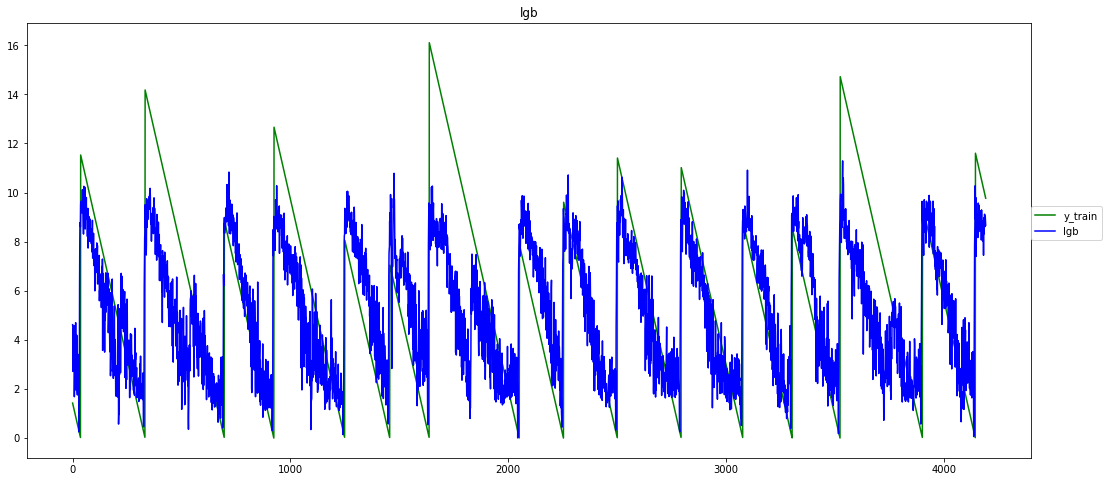

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(18, 8))
plt.plot(train_X['time_to_failure'], color='g', label='y_train')
plt.plot(val_pr, color='b', label='lgb')
plt.legend(loc=(1, 0.5));
plt.title('lgb');

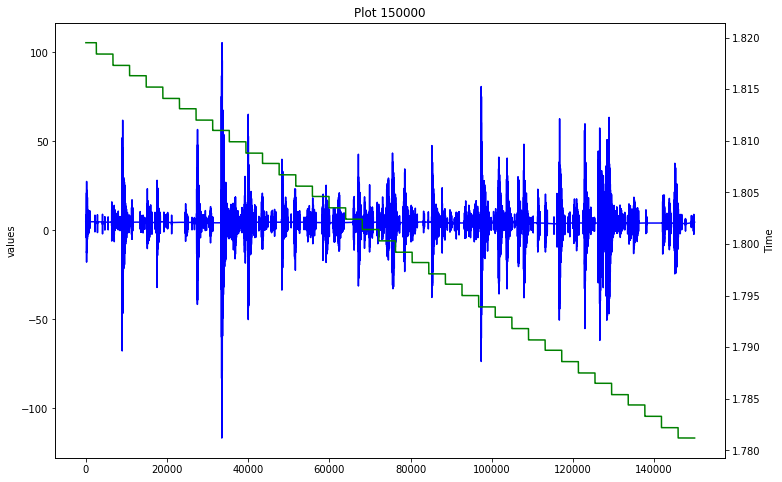

In [11]:
i=1411
import matplotlib.pyplot as plt
%matplotlib inline
_,ax1=plt.subplots(figsize=(12, 8))
plt.plot(denoise_signal(train['acoustic_data'].loc[150000*i:150000*(i+1)]),color='b')
ax1.set_ylabel('values')
ax2=ax1.twinx()
plt.plot(denoise_signal(train['time_to_failure'].loc[150000*i:150000*(i+1)]),color='g')
ax2.set_ylabel('Time')
plt.title('Plot 150000')
plt.show()

KeyError: 'mode_otn_last_begin'

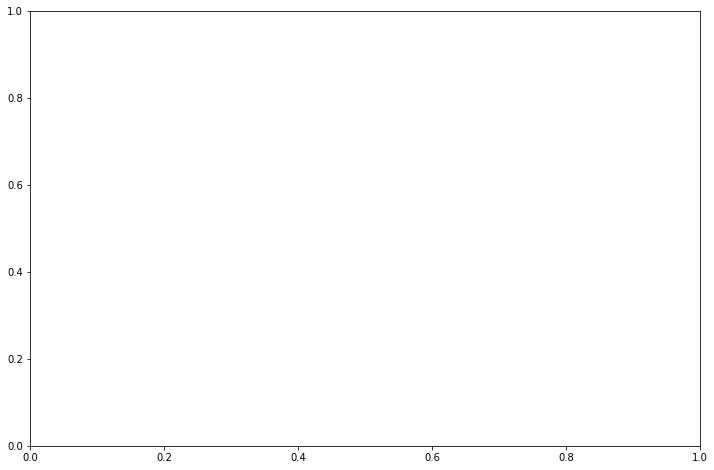

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
_,ax1=plt.subplots(figsize=(12,8))
plt.plot(train_X['mode_otn_last_begin'], color='g', label='y_train')
ax1.set_ylabel('values')
ax2=ax1.twinx()
plt.plot(train_X['time_to_failure'], color='b', label='lgb')
ax2.set_ylabel('time')
#plt.legend(loc=(1, 0.5));
plt.title('graph');

In [13]:
train_X.corr()['time_to_failure']


number_crossing_0       -0.304412
q05_roll_std_10         -0.643123
peak_feature_2          -0.338996
peak_feature_5           0.510003
peak_feature_8          -0.027434
svd_entropy             -0.527424
c3                       0.026387
diff_peaks40_max         0.232837
std_roll_percentile     -0.587568
std_roll_percentile_5   -0.614482
limit_last               0.310464
time_to_failure          1.000000
Name: time_to_failure, dtype: float64